# Programming Simple Neural Network by hand and by Pytorch

Purpose：
1. Practice programming neural network and be familier with Forward propgation and Backward propgation;
2. Be familier with Softmax and CrossEntropy;

## Preparing Data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn import datasets


iris = datasets.load_iris()
data = iris.data
target = iris.target

# transition of data to one-hot
targets = np.zeros((150, 3))
targets[:50, 0] = targets[:50, 0] + 1.
targets[50:100, 1] = targets[50:100, 1] + 1.
targets[100:, 2] = targets[100:, 2] + 1.
corpus = np.hstack((np.hstack((data, target.reshape(150,1))), targets))
np.random.shuffle(corpus)
total_data = corpus[:,:4]
total_target = corpus[:,4]      # simple index
total_targets = corpus[:, 5:]   # one-hot

# split the data to train data and test data
train_data = total_data[ :100, : ]
test_data = total_data[100: , :]
train_target = total_target[ :100]
test_target = total_target[100:]
train_target_one_hot = total_targets[ :100, : ]
test_target_ont_hot = total_targets[100: , : ]
train_data.shape, test_data.shape

((100, 4), (50, 4))

## Programming Simple Nerual Network by hand

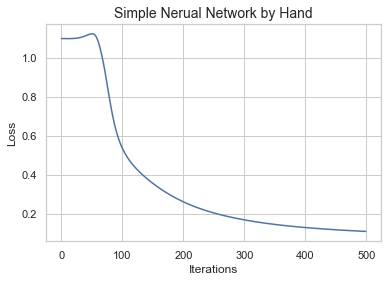

On train data:
The precision is : 98.0% 
On test data:
The precision is : 92.0% 


In [2]:
class Net1:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.001, epoch=10):
        self.lr = lr
        self.epoch = epoch
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W1 = np.random.randn(input_dim, hidden_dim) / 100
        self.W2 = np.random.randn(hidden_dim, output_dim) / 100
        
        self.losses = []
        
    def softmax(self, x):
        z_i = np.exp(x)
        return z_i / np.sum(z_i)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        
    def forward(self, x):
        self.A1 = x
        self.Z2 = np.dot(self.A1, self.W1)                                            # dim(hidden_dim,)
        self.A2 = self.sigmoid(self.Z2)
        self.Z3 = np.dot(self.A2, self.W2)                                            # dim(output_dim,)
        self.A3 = self.softmax(self.Z3)
    
    def backward(self, y):
        self.delta3 = self.A3 - y                                                     # dim(output_dim,)
        self.deltaW2 = self.delta3 * self.Z2.reshape(self.hidden_dim, 1)              # dim(hidden_dim, output_dim)
        self.deltaA2 = np.dot(self.W2, self.delta3)                                   # dim(hidden_dim,)
        self.delta2 = self.deltaA2 * self.sigmoid(self.Z2) * self.sigmoid(1 - self.Z2)        # dim(hidden_dim,)
        self.deltaW1 = self.A1.reshape(self.input_dim, 1) * self.delta2               # dim(input_dim, hidden_dim)
        
        # update gradient
        self.W1 = self.W1 - self.lr * self.deltaW1
        self.W2 = self.W2 - self.lr * self.deltaW2
        
        
    def train(self, X, Y):
        for epoch in range(self.epoch):
            # SGD
            total = np.zeros((1))
            for i in range(X.shape[0]):
                self.forward(X[i])
                self.backward(Y[i])
                
                # loss
                temp = np.sum(self.A3 * Y[i])
                total += -np.log(temp) 
            self.losses.append(total / X.shape[0])
        
        plt.plot(range(self.epoch), self.losses)
        plt.title("Simple Nerual Network by Hand", size=14)
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
            
    def precision(self, test, target):
        max_indexes = []
        for i in range(test.shape[0]):
            self.forward(test[i])
            max_index = np.argmax(self.A3)
            max_indexes.append(max_index)
        total = np.sum(np.array(max_indexes) == target)
        print("The precision is : %.1f%% " %(total / test.shape[0] * 100))
        

# test
model1 = Net1(4, 50, 3, lr=0.001, epoch=500)
model1.train(train_data, train_target_one_hot)
print("On train data:")
model1.precision(train_data, train_target)
print("On test data:")
model1.precision(test_data, test_target)

## Using Pytorch to programming Neural Network

Precision is: 64.7%


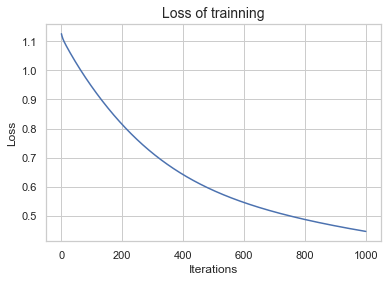

In [3]:
import torch
X = torch.from_numpy(train_data).type(torch.FloatTensor)
Y = torch.from_numpy(train_target).type(torch.LongTensor)

loss_history  = []
Epoch = 1000

class Net2(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net2, self).__init__()
        self.hidden1 = torch.nn.Linear(input_dim, hidden_dim)
        self.hidden2 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, X):
        a = torch.sigmoid(self.hidden1(X))
        z = self.hidden2(a)
        return z

model2 = Net2(4, 100, 3)
loss_function = torch.nn.CrossEntropyLoss()      # inputs of crossentropy loss don't need to go through softmax, it will automatically do it for you
optimizer = torch.optim.SGD(model2.parameters(), lr=0.01)

for epoch in range(Epoch):
    result = model2(X)
    loss = loss_function(result, Y)
    loss_history.append(loss.data.numpy())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
results = model2.forward(X)
counts = torch.sum(torch.max(results, 1)[1] == Y)

print("Precision is: %.1f%%" %(counts.data.numpy() / 1.5))
plt.plot(range(Epoch), loss_history)
plt.title("Loss of trainning", size=14)
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

## Somthing Wrong with Batch training via Programming by hand

In [4]:
class Net3:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.001, epoch=10):
        self.lr = lr
        self.epoch = epoch
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W1 = np.random.randn(input_dim, hidden_dim) / 100
        self.W2 = np.random.randn(hidden_dim, output_dim) / 100
        
        self.losses = []

    def softmax(self, x):
        temp = []
        for i in range(x.shape[0]):
            e_x = np.exp(x[i,:])
            total = np.sum(e_x)
            temp.append((e_x / total).tolist())
        return np.array(temp)     

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        
    def forward(self, X):
        self.sample_nums = len(X)  # 总样本数
        
        self.batch_Z_2 = np.dot(X, self.W1)                         # dim(150,6)
        self.batch_A_2 = self.sigmoid(self.batch_Z_2)
        self.batch_Z_3 = np.dot(self.batch_A_2, self.W2)            # dim(150,3)
        self.batch_A_3 = self.softmax(self.batch_Z_3)
        
        self.A_2 = np.average(self.batch_A_2, 0)           # dim(6,)
        self.A_1 = np.average(X, 0)                        # dim(4,)
    
    def backward(self, targets):
        # loss计算
        total = np.sum(np.exp(self.batch_Z_3), 1)
        e = np.sum(self.batch_Z_3 * targets, 1)
        loss = np.average(total - e)
        self.losses.append(loss)            # maybe something wrong here
        
        
        
        batch_delta_3 = self.batch_A_3 - targets                    # dim(150,3)
        delta_3 = np.average(batch_delta_3, 0)                            # dim(3,)
        delta_W2 = delta_3 * self.A_2.reshape(self.hidden_dim,1)          # dim(6,3)
        temp = np.average(self.sigmoid(self.batch_Z_2) * self.sigmoid(1 - self.batch_Z_2), 0)     # dim(6,)
        delta_2 = np.dot(self.W2, delta_3) * temp                         # dim(6,)
        delta_W1 = delta_2 * self.A_1.reshape(self.input_dim, 1)         # dim(4,6)

        
        # 梯度更新
        self.W1 = self.W1 - self.lr * delta_W1
        self.W2 = self.W2 - self.lr * delta_W2
        
        
    def train(self, X, Y):
        for epoch in range(self.epoch):
            self.forward(X)
            self.backward(Y)
        
        # 观察权重是否降低
        plt.plot(range(self.epoch), self.losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
            
    def precision(self, test, target):
        self.forward(test)
        max_indexes = np.argmax(self.batch_A_3, 1)
        total = np.sum(max_indexes == target)
        print("The precision is : %.1f%% " %(total / len(test) * 100))

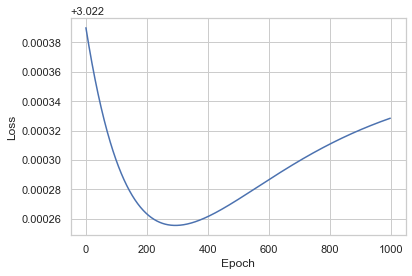

The precision is : 34.0% 


In [5]:
model3 = Net3(4, 30, 3, 0.001, 1000)
model3.train(train_data, train_target_one_hot)
model3.precision(train_data, train_target)

# Check all Vairables

In [6]:
%whos

Variable               Type                Data/Info
----------------------------------------------------
Epoch                  int                 1000
Net1                   type                <class '__main__.Net1'>
Net2                   type                <class '__main__.Net2'>
Net3                   type                <class '__main__.Net3'>
X                      Tensor              tensor([[5.8000, 2.6000, <...>3.7000, 1.5000, 0.2000]])
Y                      Tensor              tensor([1, 2, 2, 1, 0, 2,<...> 1,\n        2, 0, 1, 0])
corpus                 ndarray             150x8: 1200 elems, type `float64`, 9600 bytes
counts                 Tensor              tensor(97)
data                   ndarray             150x4: 600 elems, type `float64`, 4800 bytes
datasets               module              <module 'sklearn.datasets<...>\\datasets\\__init__.py'>
epoch                  int                 999
iris                   Bunch               {'data': array([[5.1, 3.5<.